# SIMULACIÓN | LABORATORIO 5


## Boostrap o remuestreo

In [1]:
%matplotlib notebook
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy 
from IPython.display import display, Math
import ipywidgets as widgets
import random
import scipy.stats as stats
import statistics

### Ejercicio 1
En un estudio sobre plantaciones de coihue, se ha recopilado información sobre la altura que alcanzan dichos árboles a los 20 años de edad, en diversas zonas de la región sur austral de Chile. A partir de dichos datos, estamos interesados en calcular un intervalo de confianza para la mediana de altura que alcanza esta especie a los 20 años de edad.
Para ello utilizaremos remuestreo o bootstrap.
1. Analice el código y evalue el número de muestras de bootstrap para alcanzar convergencia de la varianza estimada de la mediana.
2. Calcule el error cuadrático medio de la mediana.
3. Escoja otro estadístico de la muestra y calcule su incerteza con la técnica de boostrap
4. Compare y comente sus resultados.

In [2]:
datos = np.array([12.5,11.4,18.4,10.7,9.5,11.7,15.4,12.3,18.6, 14.7, 10.7,11.6, 10.1, 8.2, 11.4,21.1, 12.1, 7.5, 12.5, 14.7, 10.3, 5.4, 9.4, 13.8, 9.6, 11.3, 14.8, 12.6])

In [3]:
def bootstrap(datos,b):
    
    # Calcula la mediana de la muestra completa
    m = statistics.median(datos)

    # Arreglo de medianas bootstrap
    mn =[]

    # Tamaño de cada muestra generada
    n = len(datos)

    # Genera b muestras
    for i in range(b):

        # Genera muestra con reemplazo
        dat = np.random.choice(datos,size=n,replace=True)

        # Calcula su mediana y la almacena en mn
        mn.append(statistics.median(dat))

    # Calcula varianza de las medianas
    var = statistics.variance(mn)

    # Intervalo de confianza al 95%
    #rango = 1.96*math.sqrt(var)
    #display(Math('%0.2f \pm %0.2f' % (m, rango )))
    
    return var

In [4]:
# Número de muestras bootstrap a probar
b_array = [200,400,600,800,1000,2000,4000,6000,8000,10000,20000,40000,60000]

# Calcula la varianza estimada de la mediana en cada caso
varianzas = [bootstrap(datos,b) for b in b_array]

<IPython.core.display.Javascript object>


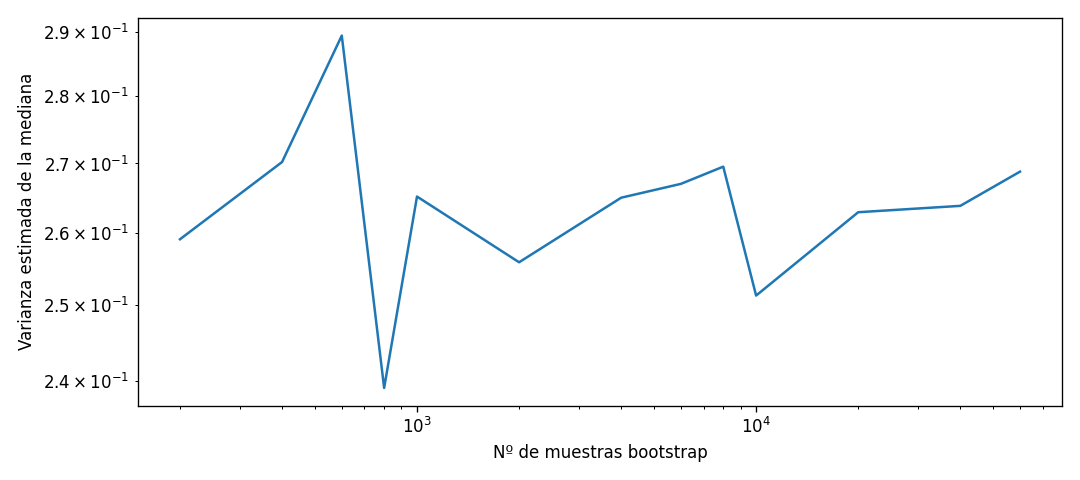

In [5]:
fig, ax = plt.subplots(1, figsize=(9,4), tight_layout= True)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Varianza estimada de la mediana')
ax.set_xlabel('Nº de muestras bootstrap')
plt.plot(b_array,varianzas)

Tras graficar reiteradas veces, notamos que en la mayoría de los casos se necesitan al rededor de 10000 muestras de bootstrap para que la varianza converja. En este caso, a un valor cercano a 0.26.

In [6]:
def MSEMediana(datos,b):
    
    # Calcula la mediana de la muestra completa
    mediana = statistics.median(datos)

    # Almacena suma de MSE
    mse = 0.0

    # Tamaño de cada muestra generada
    n = len(datos)

    # Genera b muestras
    for i in range(b):

        # Genera muestra con reemplazo
        b_muestra = np.random.choice(datos,size=n,replace=True)

        # Parte suma de MSE
        mse += (statistics.median(b_muestra) - mediana)**2
    
    # Divide por el tamaño de muestras bootstrap
    return mse/float(b)

In [7]:
print("El MSE de la mediana es:",MSEMediana(datos,10000))

El MSE de la mediana es: 0.27181525000000495


Tomando como estadístico la proporción de árboles de altura menor a 10 metros.

In [8]:
def bootstrapProp(datos,b):
    
    # Tamaño de cada muestra generada
    n = len(datos)
    
    # Calcula prop de la muestra completa
    propDatos = np.count_nonzero(datos < 10)/n

    # Arreglo de medias bootstrap
    props =[]

    # Genera b muestras
    for i in range(b):

        # Genera muestra con reemplazo
        b_muestra = np.random.choice(datos,size=n,replace=True)

        # Calcula prop y la almacena
        props.append(np.count_nonzero(b_muestra < 10)/float(n))

    # Desv Estandar * 1.96
    rango = np.sqrt(statistics.variance(props))*1.96
    
    # IC 95%
    IC = [propDatos-rango,propDatos+rango]
    
    return props,propDatos,IC

<IPython.core.display.Javascript object>


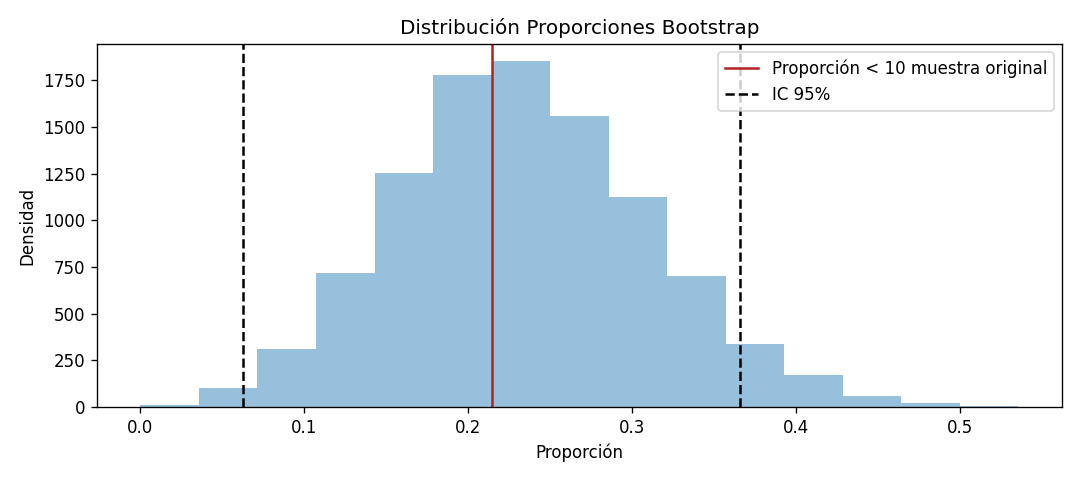

Intervalo de confianza: [0.06287798043705342, 0.3656934481343751]


In [9]:
props,propDatos,IC = bootstrapProp(datos,10000)
fig, ax = plt.subplots(1, figsize=(9,4), tight_layout= True)
ax.hist(props, color='#3182bd', alpha=0.5, bins=15)
ax.axvline(x=propDatos, color='firebrick', label='Proporción < 10 muestra original')
ax.axvline(x=IC[0], color='black', linestyle='--', label='IC 95%')
ax.axvline(x=IC[1], color='black', linestyle='--')
ax.set_title('Distribución Proporciones Bootstrap')
ax.set_xlabel('Proporción')
ax.set_ylabel('Densidad')
ax.legend();
plt.show()
print("Intervalo de confianza:",IC)

Podemos intuir que si tomamos otras muestras de la población, el 95% de las veces la proporción de árboles menores que 10 metros de estas debería ser de 6% a 36%. Dado que el grado de variabilidad es alto, podemos decir que también lo es su incerteza.

### Ejercicio 2

Suponga que los datos previamente registrados provienen de una distribución normal de parámetros $(\mu,\sigma)$

1. Calcule los estimadores máximo verosímil de $\hat{\mu}$ y $\hat{\sigma}$

In [10]:
# Utilizamos scipy
mu,sigma = stats.norm.fit(datos)
print("mu:",mu,"sigma:",sigma)

mu: 12.225000000000003 sigma: 3.3405116160766237


2. Utilice boostrap paramétrico para estimar la incerteza de $\hat{\mu}$ y $\hat{\sigma}$ . Estime el número de muestras para alcanzar convergencia en cada caso.

In [11]:
def bootstrap_parametrico(datos, b, mu, sigma):
    
    # Tamaño de cada muestra generada
    n = len(datos)
    
    # Arreglo de medias
    means = []
    
    # Arreglo de desviaciones estandar bootstrap
    sigmas = []

    # Genera b muestras
    for i in range(b):
        dat = stats.norm.rvs(mu, sigma, size=n)

        # Calcula su media y la almacena en means
        means.append(np.mean(dat))
        
        # Calcula su SD y la almacena en sigmas
        sigmas.append(np.std(dat))

    # Calcula varianza de las medias
    var_means = statistics.variance(means)
    
    # Calcula varianza de las SD
    var_sd = statistics.variance(sigmas)
    
    rango_mu = np.sqrt(var_means)*1.96
    
    print("mu=", mu, "±", rango_mu)
    
    rango_sigma = np.sqrt(var_sd)*1.96
    
    print("sigma", sigma, "±", rango_sigma)

    # Intervalo de confianza al 95%
    ##rango = 1.96*math.sqrt(var)
    #display(Math('%0.2f \pm %0.2f' % (m, rango )))
    
    return means, sigmas

In [12]:
bootstrap_parametrico(datos, 10000, mu, sigma )

mu= 12.225000000000003 ± 1.229240453495642
sigma 3.3405116160766237 ± 0.8789933088510965


([12.399497695641331,
  11.740399636267497,
  10.444419645236296,
  12.283527226541667,
  12.76807245640886,
  11.588393917958545,
  11.324110192799617,
  12.25482657210292,
  12.090634744947618,
  12.799117303146065,
  12.136973543444551,
  11.904629558403192,
  12.47470054418467,
  12.345482646132043,
  12.200153549813313,
  13.353971343457246,
  12.910285989570712,
  12.431046301511861,
  11.844592846119678,
  12.819251369983311,
  12.010715931254438,
  13.068288643052892,
  13.763317851485505,
  12.19566186173608,
  13.233548479536747,
  12.040441764320686,
  12.696332758734755,
  13.02710710542812,
  13.078792953132728,
  12.437575060202974,
  12.381377696716555,
  12.88266479207802,
  11.660129469237104,
  12.957507465396942,
  12.291836114035883,
  11.7607296340832,
  12.599678754477639,
  12.001004004852605,
  12.329483298265968,
  12.223886667625212,
  11.748916194918765,
  11.874506831471885,
  11.492848381776815,
  13.433370018368754,
  12.583513615994349,
  12.1358028259954

3. Compare y comente sus resultados.

<IPython.core.display.Javascript object>


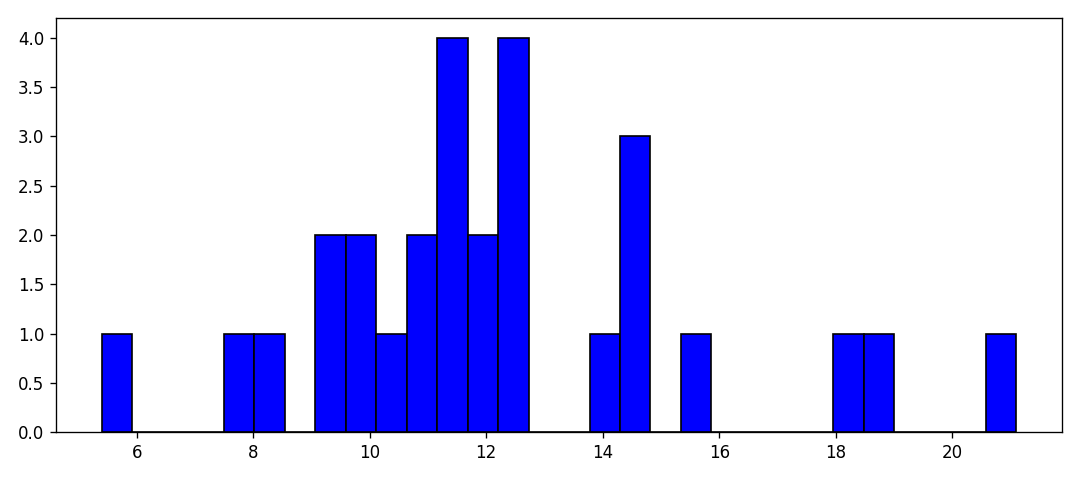

In [13]:
fig, ax = plt.subplots(1, figsize=(9,4), tight_layout= True)
ax.hist(datos, color='blue', edgecolor='black', bins=30)
plt.show()